In [8]:
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
from helpers import cfsToM3s, m3ToKm3

# In descending order for legend order
panel_areas = [600000000, 400000000, 200000000, 100000000, 50000000, 25000000, 10000000, 1000000, 100000, 0] # m^2
overall_costs = []

MAX_AREA = 640000000  # m^2
MAX_VOLUME = 32.24 * 1000000000  # m^3
MAX_HEIGHT = 100  # meters
LENGTH = 10000 # meters
MAX_BASE = 64000 # meters
ANGLE = 89.82 # 
STARTING_VOLUME = 32 * 1000000000  # starting volume of lake mead. m^3

V_in = cfsToM3s(11800)  # m^3 / s
V_dam = cfsToM3s(10083.3102)  # m^3 / s

# Background
In just a paragraph or two, introduce your project. Example questions to consider: What is the current
situation with Lake Mead? What is the proposed change? Why does it matter? This section should include
citations in the text to at least two outside sources of information.

Potential sources (cite later/after use):
https://earth.org/lake-mead-and-colorado-river-basin-water-shortage/#:~:text=Formal%20Water%20Shortage%20Declared%20for,of%20natural%20and%20anthropogenic%20activities.

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007WR006704


The Colorado River, which originates in the Rocky mountains 

### Question
How does the cost-effectiveness of floatovoltaics vs shade balls compare?

Two proposed solutions to the Lake Mead water crisis are floatovoltaics - solar panels that would float on the surface of the lake - and shade balls - plastic spheres that block sunlight in order to reduce evaporation. 

The goal of this project is to compare the ratio of effectiveness at preventing evaporation to the cost of the proposed solution, which would allow us to determine which solution is worth putting time and money into in order to minimize the ongoing water crisis.

# Modeling

### Schematic


• Using a clear, diagrammatic way of documenting fluid flows, create a captioned figure illustrating
conservation of water mass for Lake Mead. Explain.

### Equations
• Write the system of equations, including at least one ODE, that will be used to solve for lake volume
and/or height as a function of time. Explain these equations in words, including why they are
appropriate for modeling the system of interest. Make sure at least one of the non-differential terms
in the primary ODE is not a constant1

[insert variable defenitions and values]




• Discuss the primary ODE for your system. What type of ODE is it? What type of behavior do you
expect from an ODE like this?
• State how you will solve the system of equations, including any initial values.


### Assumptions
When developing this model, we made a few key assumptions & acknowledged that certain factors are outside of our control:
1. The input rate of water from the Colorado River is constant
2. The output rate of water from Lake Mead is constant
3. The shape of the lake is a triangular prism

[justify each assumption]

In [9]:
def model(V, t, V_in, V_dam, panel_area):
    '''
    Insert docstrings here
    '''
    DENSITY = 1000  # Density of water (kg/m^3)

    # maximum humidity ratio of saturated air at the same temperature as the water surface (kg/kg)  (kg H2O in kg Dry Air)
    MAX_HUM_RATIO = 0.030
    HUM_RATIO = 0.015  # humidity ratio air (kg/kg) (kg H2O in kg Dry Air)

    area = 2*V / math.sqrt(V/(LENGTH*math.tan(math.radians(ANGLE))))

    v_air = 7  # m/s

    # kg / (m^2 * h)
    Theta = 25+(19*v_air)			# v_air = velocity of air

    # this will be a function of surface area, which we can calculate from V/h
    V_evap = Theta*(area-panel_area)*(MAX_HUM_RATIO - HUM_RATIO) / (DENSITY * 3600)
    
    dVdt = V_in - V_dam - V_evap
    return dVdt

# Validation
Using data and trends for Lake Mead, show that your baseline lake model (without floatovoltaics) is reasonable.
This will lend credibility to non-baseline predictions.

# Results & Discussion
Show, explain, and discuss the results of your model. Include, at the minimum, a plot of lake volume and/or
height over time with and without floatovoltaics. Make a recommendation based on your findings and
discuss the potential impacts of the recommended path. You may optionally choose to add conclusion section
summarizing findings.

The implementation of the project has three sections - the MVP and two iterations. 

### MVP 
The MVP assumes that the input and the output of the Colorado River are constant and contains basic math for the effect of having solar panels covering the lake.



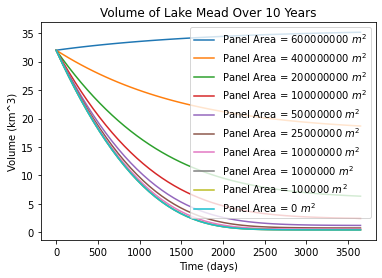

In [10]:
# MVP Plots

result = []

# represent the model time as seconds in a year
t = np.linspace(0, 31536000*10)

fig, ax = plt.subplots()

for i, panel_area in enumerate(panel_areas):
    result.append(odeint(model, STARTING_VOLUME, t, args=(V_in, V_dam, panel_area)))
    ax.plot(t/86400, m3ToKm3(result[i]), label=f'Panel Area = {panel_area} '+r'$m^2$')

ax.set_title('Volume of Lake Mead Over 10 Years')
ax.legend()
ax.set_xlabel('Time (days)')
ax.set_ylabel('Volume (km^3)')

plt.show()

### Iteration 1 - Cost Effectiveness Analsysis
The first iteration models the input as the flow rate of the Colorado River and the output as the dam ODE. Additionally, the effect of using shade balls as opposed to solar panels covering the lake is included.

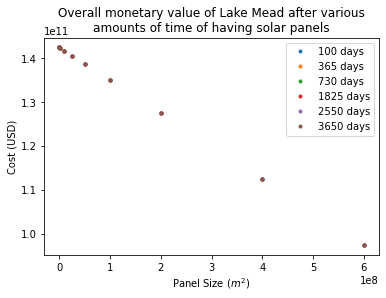

In [11]:
# Iteration 1 plots

PANEL_COST = 75  # dollar cost per square meter
WATER_COST = 4.45  # dollar cost per cubic meter of water
ELECTRICITY_COST = 0.127871428571  # dollar price of electricity per kWh
PANEL_KWATTS_PER_SECOND = 0.000257941667  # kWh/s for one square meter of panel

times = [100, 365, 365*2, 365*5, 2550, 365*10]  # days

plt.figure(1)
for time in times:
    cost_values = []
    for panel_area in panel_areas:
        t = np.linspace(0, time)
        volume = odeint(model, STARTING_VOLUME, t, args=(V_in, V_dam, panel_area))[-1][0]
        panel_electricity_price = PANEL_KWATTS_PER_SECOND*ELECTRICITY_COST*panel_area  # total dollar price of electricity for 1 second
        cost = panel_electricity_price - panel_area*PANEL_COST + volume*WATER_COST
        cost_values.append(cost)
    plt.plot(panel_areas, cost_values, '.', label = f'{time} days')


plt.legend()
plt.title('Overall monetary value of Lake Mead after various\namounts of time of having solar panels')
plt.xlabel('Panel Size (' + r'$m^2$' + ')')
plt.ylabel('Cost (USD)')

plt.show()

### Iteration 2 - Seasonal Changes
The second iteration of the model implements support for changing seasons in order to account for changes in water level at different points in time during the year.

In [12]:
# Iteration 2 Plots

# References
